Dataset of NY taxi data : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
Data dictionary: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

### Example of docker compose
services:
  db:
    container_name: postgres
    image: postgres:17-alpine
    environment:
      POSTGRES_USER: 'postgres'
      POSTGRES_PASSWORD: 'postgres'
      POSTGRES_DB: 'ny_taxi'
    ports:
      - '5433:5432'
    volumes:
      - vol-pgdata:/var/lib/postgresql/data

### Docker command for windows
```docker run -it \
   -e POSTGRES_USER="root" \
   -e POSTGRES_PASSWORD="root" \
   -e POSTGRES_DB="ny_taxi" \
   -v /"$(pwd)"/ny_taxi_postgres_data/:/var/lib/postgresql/data/\
   -p 5432:5432 \
   postgres:13````

After you have the postgres db running, run the following script in the command line: 

# -h to indicate the host
# -p to select the port
# -u for the user and -d for the name of the database
$ pgcli -h localhost -p 5432 -u root -d ny_taxi

After this, you will probably be prompt to enter the postgres user password which you should find in the docker compose.

## Docker PGadmin image

Now to connect PGadmin with postgres, we will use another docker image with pgadmin. Instructions for this can be found in pgadmin download and use container. https://www.pgadmin.org/download/pgadmin-4-container/
The command for docker is 

docker run -it \
-e PGADMIN_DEFAULT_EMAIL="admin@admin.com" \
-e PGADMIN_DEFAULT_PASSWORD="root" \
-p 8080:80 \
dpage/pgadmin4

Now you should be able to go to localhost:8080 and login to pgadmin with the set email and password.

Right click on servers and register a new server connection but before this we have to create a network. 

## Docker networking
Source: https://docs.docker.com/reference/cli/docker/network/create/
Create a network between two docker containers to allow communication between each other. We need to communicate pgadmin container with postgres container.  

The command to create the network is : docker network create pg-network 
where pg-network is the name you give to the network

Then you need to run the containers, postgres and pgadmin and include the network name
Important note: when running docker commands in several lines, spaces can cause your command not to work, verify for extra white spaces
-Connection to postgres
docker run -it \
  -e POSTGRES_USER="root" \
  -e POSTGRES_PASSWORD="root" \
  -e POSTGRES_DB="ny_taxi" \
  -v /"$(pwd)"/ny_taxi_postgres_data/:/var/lib/postgresql/data/\
  -p 5432:5432 \
  --network=pg-network \   **added line
  --name pg-database \     **added line
  postgres:13

-Connection to pgadmin
docker run -it \
  -e PGADMIN_DEFAULT_EMAIL="admin@admin.com" \
  -e PGADMIN_DEFAULT_PASSWORD="root" \
  -p 8080:80 \
  --network=pg-network \
  --name pgadmin \
  dpage/pgadmin4

So now, we are able to go to pgadmin and connect 
docker run -it \
  -e POSTGRES_USER="root" \
  -e POSTGRES_PASSWORD="root" \
  -e POSTGRES_DB="ny_taxi" \
  -v /"$(pwd)"/ny_taxi_postgres_data/:/var/lib/postgresql/data/\
  -p 5432:5432 \
  --network=pg-network \  
  --name pg-database \     
  postgres:13

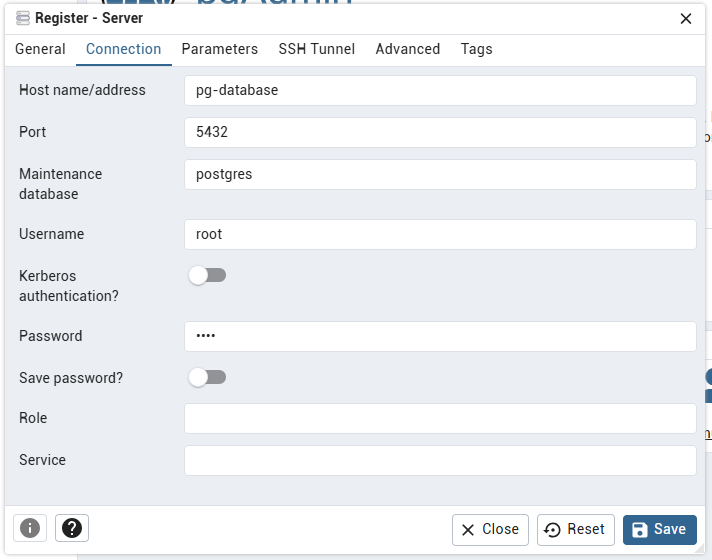

## Dockerizing the Ingestion Script

Script to populate the database through a pipeline.py. source: https://www.youtube.com/watch?v=B1WwATwf-vY&list=PL3MmuxUbc_hJed7dXYoJw8DoCuVHhGEQb&index=8&ab_channel=DataTalksClub%E2%AC%9B

In the terminal you can use the following command to convert one document to script 

$ jupyter nbconvert --to=script upload-data.ipynb

And the commands used you will find it in the ingest_data.py

After finish writing the script, you run it in the command line with this cmd:

URL="https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"

python ingest_data.py \
    --user=root \
    --password=root \
    --host=localhost \
    --port=5432 \
    --db=ny_taxi \
    --table_name=yellow_taxi_data \
    --url=${URL}


Now lets put the script in a docker

```python
#download python image to the container
FROM python:3.9.1

#install pandas
RUN apt-get install wget
RUN pip install pandas sqlalchemy psycopg2 

#create a directory in the container and set it as the working directory
WORKDIR /app

#copy the pipeline.py file from the local directory to the container (/app folder) with the same name
COPY ingest_data.py ingest_data.py


ENTRYPOINT [ "python", "ingest_data.py" ]
```

To run it you use the command
```console
docker build -t taxi_ingest:v001 .
```

After the image is built. To run it you use the same parameters passed before, but now you use docker run replacing the "python pipeline.py" and select the network to be able to connect this new docker to the postgres one:

```console
docker run -it \
    --network=pg-network \   #spicify also the docker network to allow communication through ports
    taxi_ingest:v001 \
        --user=root \
        --password=root \
        --host=pg-database \   #you need to spcify the name of the postgres container, this will be your host
        --port=5432 \
        --db=ny_taxi \
        --table_name=yellow_taxi_data \
        --url=${URL}
```



### Running Postgres and pgAdmin with Docker-Compose
Source: https://docs.docker.com/compose/
Now to make our lives easier, we will use docker compose to streamline docker configurations.

Docker Compose is a tool for defining and running multi-container applications. It is the key to unlocking a streamlined and efficient development and deployment experience.

Compose simplifies the control of your entire application stack, making it easy to manage services, networks, and volumes in a single, comprehensible YAML configuration file. Then, with a single command, you create and start all the services from your configuration file.

Since we define the services in the same docker-compose.yml file we dont need to create a network, they will be part of the same network automatically.

```python
name of file: docker-compose.yml

services:
  pg-database:
    image: postgres:13
    environment:
      - POSTGRES_USER=root
      - POSTGRES_PASSWORD=root
      - POSTGRES_DB=ny_taxi
    volumes:
      - "./ny_taxi_postgres_data:/var/lib/postgresql/data:rw"
    ports:
      - "5432:5432"

  pgadmin:
    image: dpage/pgadmin4
    environment:
      - PGADMIN_DEFAULT_EMAIL=admin@admin.com
      - PGADMIN_DEFAULT_PASSWORD=root
    ports:
      - "8080:80"
```


To run the yml file you use the command:

```python
docker-compose up
```

Another option is to use option -d which is detach mode, it will run the container but give you back the terminal. 
After you finish you should safely kill the processes with command 
```python
docker-compose down
```
